<a href="https://colab.research.google.com/github/CanKeles5/ObjectDetection/blob/main/Copy_of_Stanford_Drone_Dataset_YoloV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/dataset1.zip', 'r')
zf.extractall('dataset')
zf.close()


In [ ]:
!nvidia-smi

Tue Jan 19 16:08:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

## Prerequisites

Let's start by installing some required libraries by the YOLOv5 project:

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

We'll also install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model (this step is optional):

In [ ]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

In [ ]:
!tree dataset -L 2

clothing
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 729 (delta 36), reused 39 (delta 20), pack-reused 666
Receiving objects: 100% (729/729), 3.37 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (471/471), done.
/content/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


In [ ]:
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5x.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/yolov5/data/clothing.yaml
100% 172/172 [00:00<00:00, 293kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/yolov5/models/yolov5x.yaml
100% 1.58k/1.58k [00:00<00:00, 2.67MB/s]


In [ ]:
!python train.py --img 640 --batch 4 --epochs 30 \
  --data ./data/clothing.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_clothing --cache

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Using torch 1.7.1 CPU

Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5m.yaml', data='./data/result.yml', device='', epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1088, 1088], local_rank=-1, log_imgs=16, multi_scale=False, name='yolov5m_stanford_drone', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False,

The training took around 30 minutes on Tesla P100. The best model checkpoint is saved to `weights/best_yolov5x_clothing.pt`.

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

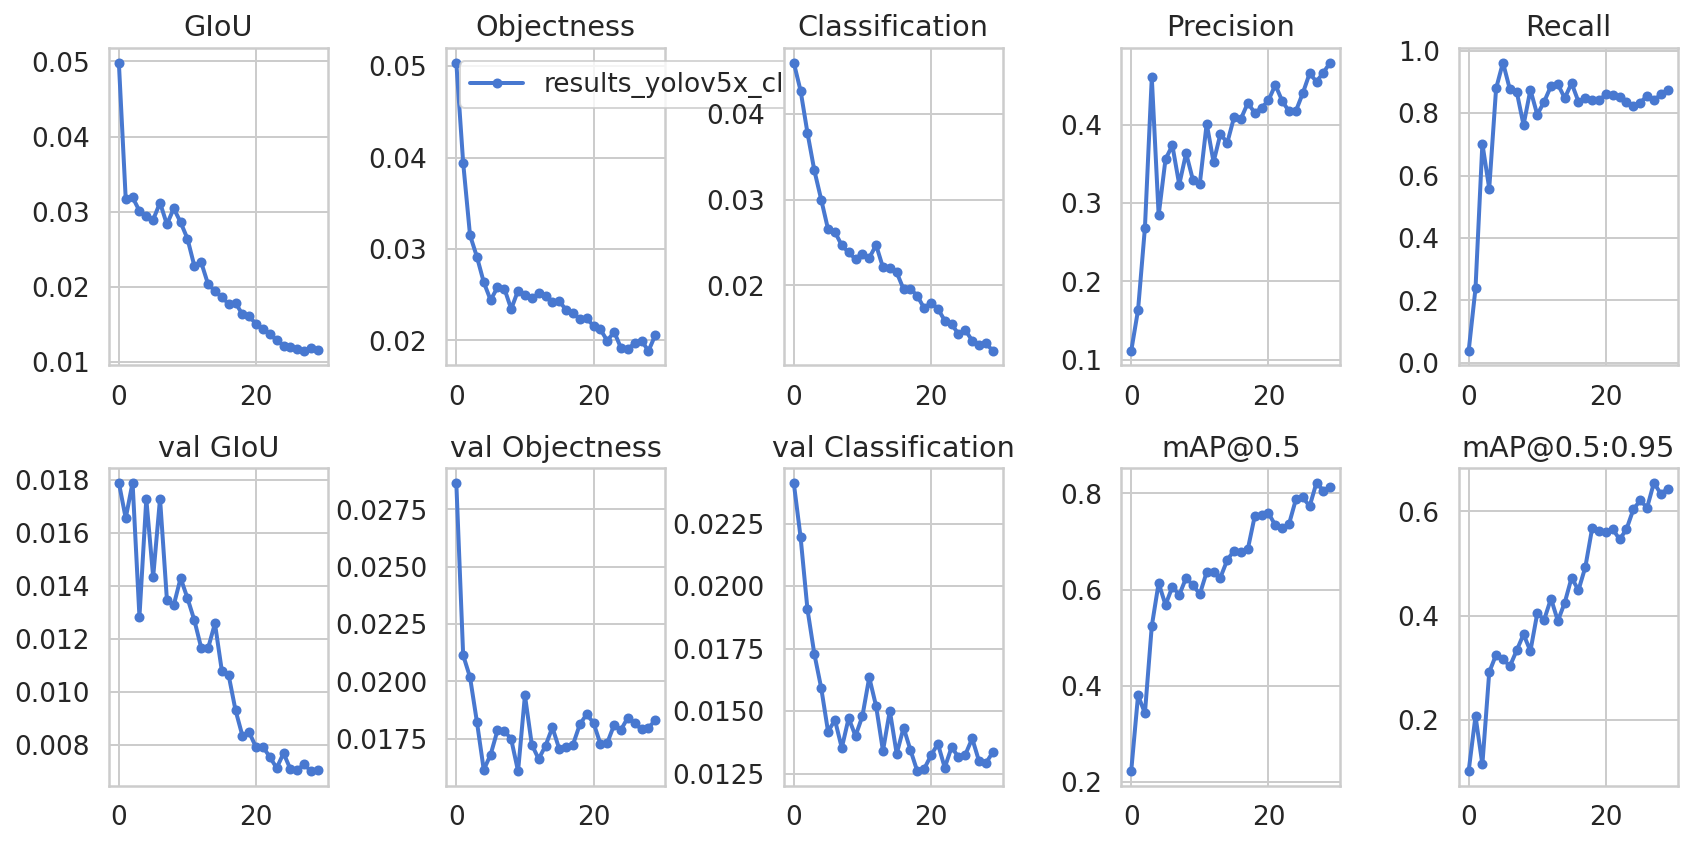

In [ ]:
from utils.utils import plot_results

plot_results();

Looks like the mean average precision (mAP) is getting better throughout the training. The model might benefit from more training, but it is good enough.

## Making predictions

Let's pick 50 images from the validation set and move them to `inference/images` to see how our model does on those:

In [ ]:
!find ../clothing/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./inference/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_yolov5x_clothing.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.4 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [ ]:
!python detect.py --weights weights/best_yolov5x_clothing.pt \
  --img 640 --conf 0.4 --source ./inference/images/

We'll write a helper function to show the results:

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Here are some of the images along with the detected clothing:

In [ ]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:22]
show_grid(img_paths)

To be honest with you. I am really blown away with the results!